In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
import time
from tqdm import tqdm

from graph_generation import create_ER, dataset_nclass_ER, dataset_regression_ER
from models import GCN, GCNEmbed
from train import Trainer, Dataset
from embedding import Embedding
from experiments import experiment_embedding

import torch
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats

import yaml

In [2]:
config = yaml.safe_load(open("configs.yml"))

In [3]:
# Dataset con cluster di grafi attorno a una p data
dataset_grafi_nx, dataset_labels, list_p= dataset_nclass_ER(config)

# Dataset con una distribuzione uniforme di grafi di p diversa
#dataset_grafi_nx, dataset_labels = dataset_regression_ER(config)

Mean connectivity for each node: 12.956 p=0.05
Mean connectivity for each node: 77.685 p=0.3


In [5]:
embeddings, trainer, test_loss_list = experiment_embedding(config, dataset_grafi_nx, dataset_labels, list_p, cont_p=False)

GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 32)
    (1): GCNConv(32, 1)
  )
  (pools): ModuleList()
  (leaky): LeakyReLU(negative_slope=0.03)
)
MSELoss()
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:30<00:00, 19.59it/s]


Tempo impiegato: 30.745939254760742
runs/lr-0.01_epochs2500_bs100_neurons-1-32-1_17Jun_15-57-57
Run training for 2500 epochs
Epoch: 0	Test loss: 0.0004671459603640768 	 Explained Variance: [array(nan, dtype=float32)]
Epoch: 100	Test loss: 0.0001763661495513386 	 Explained Variance: [array(nan, dtype=float32)]
Epoch: 200	Test loss: 0.00017476431611511441 	 Explained Variance: [array(nan, dtype=float32)]
Epoch: 300	Test loss: 0.0001631461549550295 	 Explained Variance: [array(nan, dtype=float32)]
Epoch: 400	Test loss: 7.965919923865132e-05 	 Explained Variance: [array(nan, dtype=float32)]
Epoch: 500	Test loss: 1.1459179222583771e-05 	 Explained Variance: [array(nan, dtype=float32)]
Epoch: 600	Test loss: 3.5255049523483547e-06 	 Explained Variance: [array(nan, dtype=float32)]
Epoch: 700	Test loss: 1.9098680544023712e-06 	 Explained Variance: [array(nan, dtype=float32)]
Epoch: 800	Test loss: 1.8301817666118343e-06 	 Explained Variance: [array(nan, dtype=float32)]
Epoch: 900	Test loss: 2.27

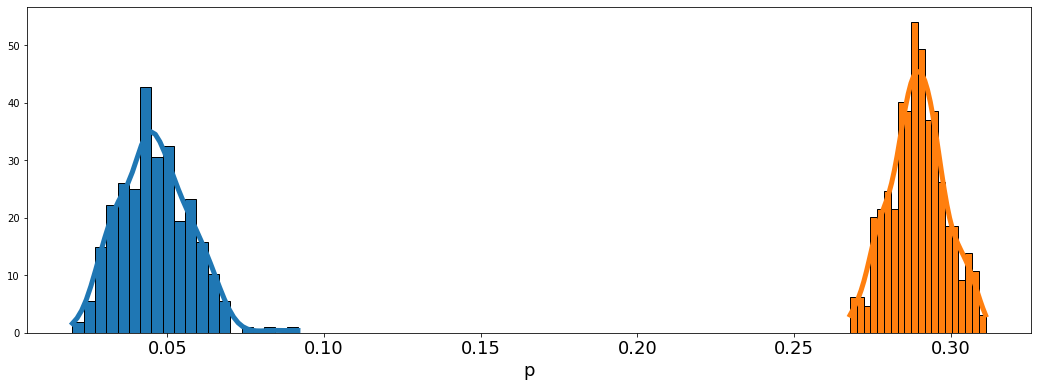

In [6]:
def intorno(p_teorica, p_attuali, soglia):
    mask = []
    for p in p_attuali:
        if p > p_teorica - soglia and p < p_teorica + soglia:
            mask.append(True)
        else:
            mask.append(False)
    return mask
    
plt.figure(figsize=(18, 6)) #, dpi=60)
for p in list_p:
    #mask_int = np.argwhere(embeddings.embedding_labels==p).flatten()
    mask_int = np.argwhere(intorno(p, embeddings.embedding_labels, 0.05)).flatten()
    emb = embeddings.embeddings_array[mask_int].flatten()
    
    h,e = np.histogram(emb, bins=20, density=True)
    x = np.linspace(e.min(), e.max())
    plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

    kde = stats.gaussian_kde(emb)
    plt.plot(x, kde.pdf(x),  lw=5, label='KDE')
    
plt.xlabel('p', fontsize=18)
plt.xticks(fontsize=18) 
plt.show()

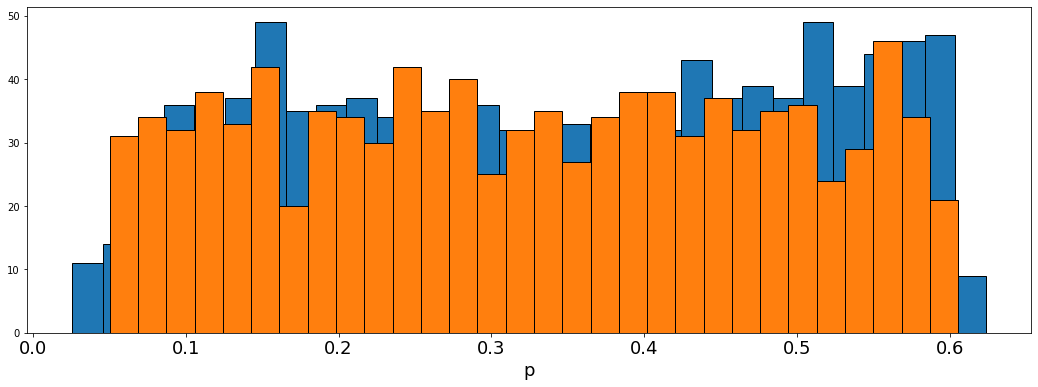

In [7]:
# Senza classi, distribuzione uniforme di probabilità

plt.figure(figsize=(18, 6)) #, dpi=60)

emb = embeddings.embeddings_array.flatten()
h,e = np.histogram(emb, bins=30, density=False)
x = np.linspace(e.min(), e.max())
plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

lab = embeddings.embedding_labels
h,e = np.histogram(lab, bins=30, density=False)
x = np.linspace(e.min(), e.max())
plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')
    
plt.xlabel('p', fontsize=18)
plt.xticks(fontsize=18) 
plt.show()

In [ ]:
import networkx as nx
num_nodes = config['graph_dataset']['Num_nodes']
#total_links = num_nodes* (num_nodes-1) / 2
actual_p = np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() / (num_nodes-1) for t in trainer.dataset.dataset])

In [ ]:
plt.figure(figsize=(18, 4)) #, dpi=60)
for p in list_p:
    #mask_int = np.argwhere(embeddings.embedding_labels==p).flatten()
    mask_int = np.argwhere(intorno(p, embeddings.embedding_labels, 0.05)).flatten()
    h,e = np.histogram(actual_p[mask_int], bins=10, density=False)
    x = np.linspace(e.min(), e.max())
    plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')
plt.show()

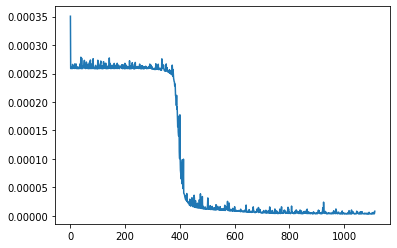

In [6]:
plt.plot(test_loss_list)
#plt.ylim(0, 0.00002)

In [ ]:
#plt.figure(figsize=(18, 6)) #, dpi=60)
for p in list_p:
    mask_int = np.argwhere(intorno(p, embeddings.embedding_labels, 0.05)).flatten()
    plt.scatter(actual_p[mask_int], embeddings.embeddings_array[mask_int].flatten()) #, s=area, c=colors, alpha=0.5)
    # correlazione tra target e prediction
    correlaz = np.corrcoef(embeddings.embeddings_array[mask_int].flatten(), actual_p[mask_int])[0,1]
    plt.title(f"P = {p}     corr = {correlaz}")
    plt.show()

In [11]:
np.sqrt(np.sum((embeddings.embeddings_array.flatten() - embeddings.embedding_labels)**2)) / len(embeddings.embeddings_array)

0.000928494682020772

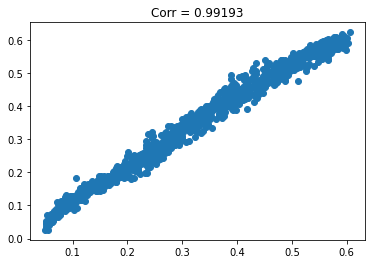

In [9]:
plt.scatter(embeddings.embedding_labels, embeddings.embeddings_array.flatten()) #, s=area, c=colors, alpha=0.5)
# correlazione tra target e prediction
correlaz = np.corrcoef(embeddings.embeddings_array.flatten(), embeddings.embedding_labels)[0,1]
error = np.sqrt(np.sum((embeddings.embeddings_array.flatten() - embeddings.embedding_labels)**2))
plt.title(f"Corr = {round(correlaz,5)}")
plt.show()

30.416735

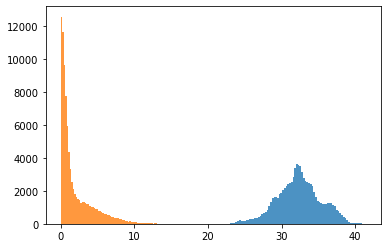

In [20]:
plt.hist(embeddings.inter_dists, bins=80, alpha=0.8)
plt.hist(embeddings.intra_dists, bins=80, alpha=0.8)
    
mean_intra = np.mean(embeddings.intra_dists)
mean_inter = np.mean(embeddings.inter_dists)
distance_of_means = mean_inter - mean_intra
distance_of_means

# Vedo cosa fa su altri grafi che non ha mai visto, con p diversa

In [ ]:
config['graph_dataset']['list_p'] = [0.03, 0.2]
dataset_grafi_nx, dataset_labels, list_p = dataset_nclass_ER(config)
trainer.load_dataset(dataset_grafi_nx, dataset_labels)
whole_data = trainer.dataset.dataset_pyg
all_data_loader = DataLoader(whole_data, batch_size=trainer.dataset.bs, shuffle=False) 
embeddings_array2 = trainer.take_embedding(all_data_loader)
embeddings_array2 = np.array([emb.cpu().detach().numpy() for emb in embeddings_array2])

embeddings2 = Embedding(embeddings_array2, trainer.dataset.dataset, trainer.dataset.labels, list_p)

In [ ]:
plt.figure(figsize=(18, 4))
h,e = np.histogram(embeddings2.embeddings_array.flatten(), bins=30, density=False)
x = np.linspace(e.min(), e.max())
plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

In [ ]:
actual_p2 = np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() / (num_nodes-1) for t in trainer.dataset.dataset])
for p in list_p:
    mask_int = np.argwhere(intorno(p, embeddings2.embedding_labels, 0.15)).flatten()
    plt.scatter(actual_p2[mask_int], embeddings2.embeddings_array[mask_int].flatten()) #, s=area, c=colors, alpha=0.5)
    # correlazione tra target e prediction
    correlaz = np.corrcoef(embeddings2.embeddings_array[mask_int].flatten(), actual_p2[mask_int])[0,1]
    plt.title(f"P = {p}     corr = {correlaz}")
    plt.show()